In [1]:
%matplotlib inline


# Image alignment and registration


**Stephen Jesse, Alex Belianinov, Suhas Somnath**

* Institute for Functional Imaging of Materials
* Center for Nanophase Materials Sciences

Oak Ridge National Laboratory, Oak Ridge TN 37831, USA

7/29/2015

Often scientists find themselves wanting to compare data of various origins on the same sample that has a location of
interest where multiple experiments have been carried out. Often, these data sets may not have the same resolution, not
have been captured over the exact same region, be distorted in different ways due to drift, and even have different
dimensionality. In this example, we will make use of algorithms which attempt to find the best alignment transformation
between data sets.

Below, the Normalized Topo Image is a result of STM (scanning tunneling microscope) imaging captured prior to
collecting a lower spatial resolution, 3D scanning tunneling spectroscopic (STS) data set that experienced drift as
is evident shown in Z Channel Spectroscopy (where Z is height roughly corresponding to topography). We would like to
map the spectroscopic result onto exact locations in the 2D map (high resolution) to correlate topo features to the
electronic effects captured by STS. To do this, the image (and the associated full 3D data set) on the right needs to
be transformed to look like the image on the left.



Gather our tools and load necessary libraries



In [2]:
from __future__ import print_function, division, unicode_literals  # ensure python3 compatibility
import numpy as np  # fast math
from warnings import warn
import matplotlib.pyplot as plt  # plotting
import h5py  # reading the data file
import os  # file operations
from scipy import interpolate, stats  # various convenience tools
from skimage import transform  # image processing and registration
import subprocess
import sys

import pyUSID as usid # used mainly for visualization purposes here


/Users/ba8/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Defining a few handy functions that will be reused multiple times



In [3]:
def twin_image_plot(images, titles, cmap=plt.cm.viridis):
    """
    Handy function that plots two images side by side with colorbars

    Parameters
    ----------
    images : list or array-like
        List of two images defined as 2D numpy arrays
    titles : list or array-like
        List of the titles for each image
    cmap : (Optional) matplotlib.pyplot colormap object or string
        Colormap to use for displaying the images

    Returns
    -------
    fig : Figure
        Figure containing the plots
    axes : 1D array_like of axes objects
        Axes of the individual plots within `fig`
    """
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    for axis, img, title in zip(axes.flat, images, titles):
        usid.plot_utils.plot_map(axis, img, cmap=cmap)
        axis.set_title(title)
    fig.tight_layout()
    return fig, axes


def normalize_image(image):
    """
    Normalizes the provided image from 0 to 1

    Parameters
    ----------
    image : np.array object
        Image to be normalized

    Returns
    -------
    image : np.array object
        Image normalized from 0 to 1
    """
    return (image - np.amin(image)) / (np.amax(image) - np.amin(image))

Load the data from the hdf5 file
--------------------------------
We will be using an data file available on our GitHub project page by default. You are encouraged
to download this document as a Jupyter Notebook (button at the bottom of the page) and use your own data instead.
When using your own data, you can skip this cell and provide the path to your data using the variable - h5_path

We begin by loading the high resolution STM image, the Z component image of the spectroscopic data set, and the
spectroscopic data set itself



In [4]:
h5_path = '../Data/sts_data_image_registration.h5'

print('Working on:\n' + h5_path)

with h5py.File(h5_path, mode='r') as h5_f:
    sts_spectral_data = h5_f['sts_spectra'][()]  # STS spectral data set
    high_res_topo = h5_f['stm_topography'][()]  # STM image
    sts_z_contr = h5_f['sts_z_contrast'][()]  # STS Z contrast image

Working on:
../Data/sts_data_image_registration.h5


Normalize images
----------------



In [5]:
high_res_topo = normalize_image(high_res_topo)
sts_z_contr = normalize_image(sts_z_contr)

Shapes of datasets
------------------



In [6]:
print('STS Spectra shape:', sts_spectral_data.shape)
print('STM Topography shape:', high_res_topo.shape)
print('STS Z contrast shape:', sts_z_contr.shape)

STS Spectra shape: (40, 40, 256)
STM Topography shape: (1024, 1024)
STS Z contrast shape: (40, 40)


visualization
--------------------------------



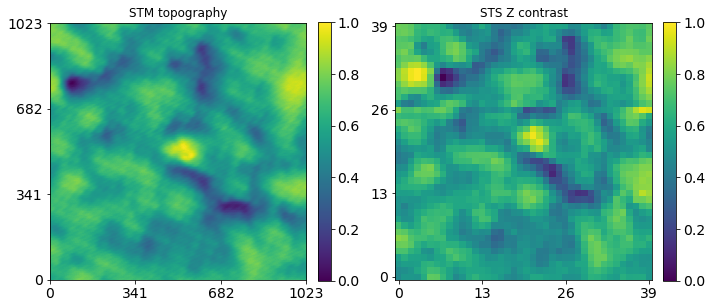

In [7]:
fig, axes = twin_image_plot([high_res_topo, sts_z_contr],
                            ['STM topography', 'STS Z contrast'])

Interpolate image and the Z channel data
----------------------------------------
Since our goal is to maximize overlap between the two datasets, we should create some additional datasets with
matching sizes. The Topo image data is 1024 x 1024 pixels, whereas the STS data is 40 x 40 spatial pixels (plus a 3rd
dimension of 256 points)

Let’s create two additional images – an interpolated STS image that is now 1024 x 1024 and a reduced Topo image
that’s 40 x 40

First we create an interpolant model, and then evaluate it at an interval that would give us the desired image size



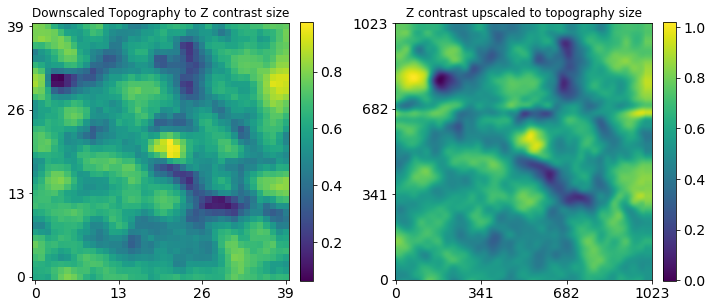

In [8]:
z_shape = sts_z_contr.shape
topo_shape = high_res_topo.shape

z_upscaler = interpolate.RectBivariateSpline(np.arange(z_shape[0]),
                                             np.arange(z_shape[1]),
                                             sts_z_contr)

# we now use the instance of the class to run it on a new set of values, which
# are still 1 to 40, but now take 40/1024 size steps returning 1024x1024 image
z_upscaled = z_upscaler(np.arange(0, z_shape[0], z_shape[0] / topo_shape[0]),
                        np.arange(0, z_shape[1], z_shape[1] / topo_shape[1]))

# repeat the process for downscaling as above, but simply reverse the direction
# feed the fine steps first & then...
topo_downscaler = interpolate.RectBivariateSpline(np.arange(0, z_shape[0], z_shape[0] / topo_shape[0]),
                                                  np.arange(0, z_shape[1], z_shape[1] / topo_shape[1]),
                                                  high_res_topo)

# use the class with only big steps, downscalign to a 40x40
topo_downscaled = topo_downscaler(np.arange(z_shape[0]),
                                  np.arange(z_shape[1]))

# visualization
fig, axes = twin_image_plot([topo_downscaled, z_upscaled],
                            ['Downscaled Topography to Z contrast size',
                             'Z contrast upscaled to topography size'])

Preparing for image registration
----------------------------------------
We now have a choice to make – whether we want to register two 40 x 40 images: Reduced Topo and the original STS, or
register the two 1024 x 1024 images: Original Topo and the interpolated STS, or do both.

If you have the time and resources, doing both is a good idea to get a handle on the quality of the registration.
Let’s try mapping the larger images in this example

Before getting started, it’s a good idea to also think about what data you’d like to use a reference and which data
should get transformed. Data that is to remain invariant is referred to as the ‘fixed’ image and the data to get the
transformation is referred to as ‘moving.’ In our case we want to map the STS data onto the image data, so Topo is
‘fixed’ and STS is ‘moving’

Python does not automatically calculate a transformation matrix for you. This is only possible if your images contain
similar features, which is the case here, as this quick registration is intensity based. There are ways to do this in
Python using an OpenCV library. Since this library isn’t installed natively with Anaconda, I invite you to explore
those concepts on your own.
You have to specify a transform matrix on your own, which is essentially a coordinate matching problem. This seems
harder initially, but for most of the data this is the only way forward because features will not match in different
information channels (topography & Raman for example)

We have selected few points quickly here. As the number of points is increased and the coordinates are more carefully
selected, the registration quality improves substantially



In [9]:
# First normalize the up and downscaled images:
z_upscaled = normalize_image(z_upscaled)
topo_downscaled = normalize_image(topo_downscaled)

# define the topography as the image that is fixed and the upscaled Z contrast image as the one that moves
# during the image registration
fixed = high_res_topo
moving = z_upscaled

# Define the points that are common:
src = [(536, 482),
       (100, 785),
       (745, 294),
       (604, 918)]
dst = [(561, 527),
       (193, 800),
       (749, 332),
       (678, 946)]

Let's visualize the pointers on the two images



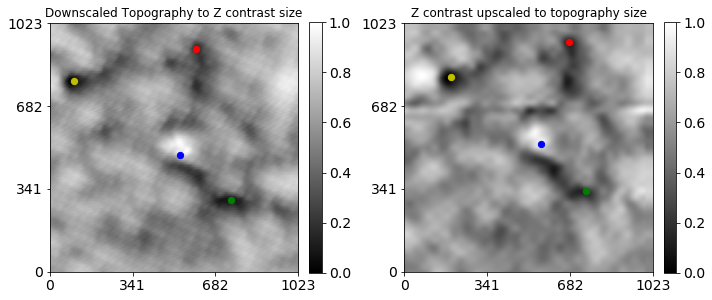

In [10]:
# First plot the two images
fig, axes = twin_image_plot([high_res_topo, z_upscaled],
                            ['Downscaled Topography to Z contrast size',
                             'Z contrast upscaled to topography size'],
                            cmap='gray')

# Defining a quick function that plots markers on an image with different colors
def plot_markers(axis, coordinates, colors):
    for clr, point in zip(colors, coordinates):
        axis.scatter(point[0], point[1], color=clr, s=40)

# Now add the markers
pointer_colors = ['b','y', 'g', 'r']
plot_markers(axes[0], src, pointer_colors)
plot_markers(axes[1], dst, pointer_colors)

Its also a good idea to look at the overlaid raw data to gauge the difficulty of the transformation prior to starting



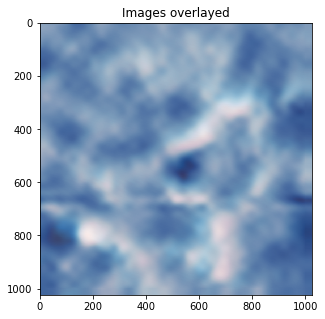

In [11]:
fig, axis = plt.subplots(figsize=(5, 5))
axis.imshow(fixed, cmap='Reds', alpha=0.8)
axis.imshow(moving, cmap='Blues', alpha=0.8)
axis.set_title('Images overlayed')

Image Registration
----------------------------------------
Before starting the registration, we need to provide an optimizer configuration and a metric. OPTIMIZER contains
settings used to configure the intensity similarity optimization.  METRIC configures the image similarity metric to
be used during registration.

The next set of statements populates a transform_cell with different types of registrations available:

* Translation – translation types of distortion
* Rigid – translation and rotation types of distortion
* Similarity – translation, rotation and scale types of distortion
* Affine -- translation, rotation, scale and shear types of distortion

In cases when you aren’t sure which transformation is best, and time is permitting. All 4 can be tried.

Lets take a closer look inside the transformation process:

Inside this loop we are registering an image, getting the transform, applying it to the ‘moving’ data set and
inspecting the results.
Since we are not sure which transform to pick, we are trying all of them one at a time – hence why this code is
inside a ‘for’ loop
We use the Pearson Correlation to look at how well (higher number is better) each of the transforms performed



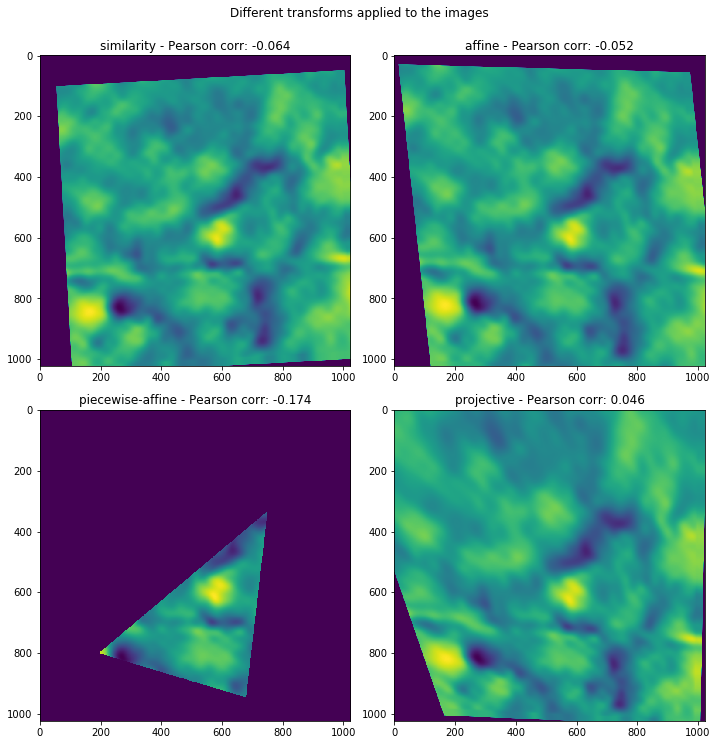

In [12]:
trans_names = ['similarity', 'affine', 'piecewise-affine', 'projective']  # transform list

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for tform_type, axis in zip(trans_names, axes.flat):  # looping through transforms

    # build the model
    tform = transform.estimate_transform(tform_type, np.array(src), np.array(dst))

    # use the model
    raw_corrected_Z = transform.warp(moving, inverse_map=tform.inverse, output_shape=np.shape(moving))

    # one way to do correlations
    corr = stats.pearsonr(np.reshape(fixed, [1024 * 1024, 1]),
                          np.reshape(raw_corrected_Z, [1024 * 1024, 1]))[0][0]

    # visualize the transformation
    axis.set_title(tform_type + ' - Pearson corr: ' + str(np.round(corr, 3)))
    axis.imshow(raw_corrected_Z)

fig.suptitle('Different transforms applied to the images', y=1.03)
fig.tight_layout()